## Simple LightGBM without Blending - Modified
- Referecne from https://www.kaggle.com/mfjwr1/simple-lightgbm-without-blending

In [1]:
import datetime
import gc
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import warnings

from contextlib import contextmanager
from pandas.core.common import SettingWithCopyWarning
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold

warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [3]:
# rmse
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [4]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [5]:
# Display / plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[['feature', 'importance']]\
        .groupby('feature')\
        .mean()\
        .sort_values(by='importance', ascending=False)[:40].index
    best_features_df = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x='importance',
                y='feature',
                data=best_features_df.sort_values(by='importance', ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
#     plt.savefig('lgbm_importances.png')

In [6]:
# reduce memory
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [7]:
# preprocessing train & test
def train_test(num_rows=None):
    
    # load csv
    train_df = pd.read_csv('../input/train.csv', index_col=['card_id'], nrows=num_rows)
    test_df = pd.read_csv('../input/test.csv', index_col=['card_id'], nrows=num_rows)
    print('Train samples: {0}, test samples: {1}'.format(len(train_df), len(test_df)))

    # reference date to divide historical and new transactions 
    ref_date = pd.to_datetime('2018-02-01')
    
    # outlier
    train_df['outliers'] = 0
    train_df.loc[train_df['target'] < -30, 'outliers'] = 1

    # set target as nan in test
    test_df['target'] = np.nan

    # merge train and test
    df = train_df.append(test_df)

    del train_df, test_df
    gc.collect()

    # convert to datetime
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])

    # datetime features
    df['quarter'] = df['first_active_month'].dt.quarter
    df['elapsed_time'] = (ref_date - df['first_active_month']).dt.days

    df['days_feature1'] = df['feature_1'] * df['elapsed_time']
    df['days_feature2'] = df['feature_2'] * df['elapsed_time']
    df['days_feature3'] = df['feature_3'] * df['elapsed_time']

    df['days_feature1_ratio'] = df['feature_1'] / df['elapsed_time']
    df['days_feature2_ratio'] = df['feature_2'] / df['elapsed_time']
    df['days_feature3_ratio'] = df['feature_3'] / df['elapsed_time']

    # one hot encoding
    df, new_columns = one_hot_encoder(df, nan_as_category=False)

    for f in ['feature_1', 'feature_2', 'feature_3']:
        order_label = df.groupby([f])['outliers'].mean()
        df[f] = df[f].map(order_label)

    df['feature_sum'] = df['feature_1'] + df['feature_2'] + df['feature_3']
    df['feature_mean'] = df['feature_sum'] / 3
    df['feature_max'] = df[['feature_1', 'feature_2', 'feature_3']].max(axis=1)
    df['feature_min'] = df[['feature_1', 'feature_2', 'feature_3']].min(axis=1)
    df['feature_var'] = df[['feature_1', 'feature_2', 'feature_3']].std(axis=1)

    return df

In [8]:
# preprocessing historical transactions
def historical_transactions(num_rows=None):
    # load csv
    hist_df = pd.read_csv('../input/historical_transactions.csv', nrows=num_rows)

    # reference date to divide historical and new transactions
    ref_date = pd.to_datetime('2018-02-01')
    
    # fillna
    hist_df['category_2'].fillna(1.0, inplace=True)
    hist_df['category_3'].fillna('A', inplace=True)
    hist_df['merchant_id'].fillna('M_ID_00a6ca8a8a', inplace=True)
    hist_df['installments'].replace(-1, np.nan, inplace=True)
    hist_df['installments'].replace(999, np.nan, inplace=True)
    # add 1 to avoid division by 0
    hist_df['installments'] += 1

    # trim
    hist_df['purchase_amount'] = hist_df['purchase_amount'].apply(lambda x: min(x, 0.8))

    # Y/N to 1/0
    hist_df['authorized_flag'] = hist_df['authorized_flag'].map({'Y': 1, 'N': 0}).astype(int)
    hist_df['category_1'] = hist_df['category_1'].map({'Y': 1, 'N': 0}).astype(int)
    hist_df['category_3'] = hist_df['category_3'].map({'A': 0, 'B': 1, 'C': 2})

    # datetime features
    hist_df['purchase_date'] = pd.to_datetime(hist_df['purchase_date'])
    hist_df['month'] = hist_df['purchase_date'].dt.month
    hist_df['day'] = hist_df['purchase_date'].dt.day
    hist_df['hour'] = hist_df['purchase_date'].dt.hour
    hist_df['weekofyear'] = hist_df['purchase_date'].dt.weekofyear
    hist_df['weekday'] = hist_df['purchase_date'].dt.weekday
    hist_df['weekend'] = (hist_df['purchase_date'].dt.weekday >= 5).astype(int)
    hist_df['day_part'] = 'Morning'
    hist_df.loc[(hist_df['hour'] > 12) & (hist_df['hour'] <= 18), 'day_part'] = 'Afternoon'
    hist_df.loc[(hist_df['hour'] > 18) & (hist_df['hour'] <= 24), 'day_part'] = 'Evening'  
    
    # additional features
    hist_df['price'] = hist_df['purchase_amount'] / hist_df['installments']

    #Christmas: December 25 2017
    hist_df['Christmas_Day_2017']=(pd.to_datetime('2017-12-25') - hist_df['purchase_date']).dt.days\
        .apply(lambda x: x if x > 0 and x < 100 else 0)
    #Mothers Day: May 14 2017
    hist_df['Mothers_Day_2017']=(pd.to_datetime('2017-06-04') - hist_df['purchase_date']).dt.days\
        .apply(lambda x: x if x > 0 and x < 100 else 0)
    #Fathers day: August 13 2017
    hist_df['Fathers_day_2017']=(pd.to_datetime('2017-08-13') - hist_df['purchase_date']).dt.days\
        .apply(lambda x: x if x > 0 and x < 100 else 0)
    #Childrens day: October 12 2017
    hist_df['Children_day_2017']=(pd.to_datetime('2017-10-12') - hist_df['purchase_date']).dt.days\
        .apply(lambda x: x if x > 0 and x < 100 else 0)
    #Valentine's Day : 12th June, 2017
    hist_df['Valentine_Day_2017']=(pd.to_datetime('2017-06-12') - hist_df['purchase_date']).dt.days\
        .apply(lambda x: x if x > 0 and x < 100 else 0)
    #Black Friday : 24th November 2017
    hist_df['Black_Friday_2017']=(pd.to_datetime('2017-11-24') - hist_df['purchase_date']).dt.days\
        .apply(lambda x: x if x > 0 and x < 100 else 0)
    #Mothers Day: May 13 2018
    hist_df['Mothers_Day_2018']=(pd.to_datetime('2018-05-13') - hist_df['purchase_date']).dt.days\
        .apply(lambda x: x if x > 0 and x < 100 else 0)

    hist_df['month_diff'] = ((ref_date - hist_df['purchase_date']).dt.days) // 30
    hist_df['month_diff'] += hist_df['month_lag']

    # additional features
    hist_df['duration'] = hist_df['purchase_amount'] * hist_df['month_diff']
    hist_df['amount_month_ratio'] = hist_df['purchase_amount'] / hist_df['month_diff']

    # reduce memory usage
    hist_df = reduce_mem_usage(hist_df)

    aggs = {}

    for col in ['subsector_id', 'merchant_id', 'merchant_category_id']:
        aggs[col] = ['nunique']

    for col in ['month', 'hour', 'weekofyear', 'weekday', 'day']:
        aggs[col] = ['nunique', 'mean', 'min', 'max']

    aggs['purchase_amount'] = ['sum', 'max', 'min', 'mean', 'var', 'skew']
    aggs['installments'] = ['sum', 'max', 'mean', 'var', 'skew']
    aggs['purchase_date'] = ['max', 'min']
    aggs['month_lag'] = ['max', 'min', 'mean', 'var', 'skew']
    aggs['month_diff'] = ['max', 'min', 'mean', 'var', 'skew']
    aggs['authorized_flag'] = ['mean']
    aggs['weekend'] = ['mean'] # overwrite
    aggs['weekday'] = ['mean'] # overwrite
    aggs['day'] = ['nunique', 'mean', 'min'] # overwrite
    aggs['category_1'] = ['mean']
    aggs['category_2'] = ['mean']
    aggs['category_3'] = ['mean']
    aggs['card_id'] = ['size', 'count']
    aggs['price'] = ['sum', 'mean', 'max', 'min', 'var']
    aggs['Christmas_Day_2017'] = ['mean']
    aggs['Mothers_Day_2017'] = ['mean']
    aggs['Fathers_day_2017'] = ['mean']
    aggs['Children_day_2017'] = ['mean']
    aggs['Valentine_Day_2017'] = ['mean']
    aggs['Black_Friday_2017'] = ['mean']
    aggs['Mothers_Day_2018'] = ['mean']
    aggs['duration']=['mean', 'min', 'max', 'var', 'skew']
    aggs['amount_month_ratio']=['mean', 'min', 'max', 'var', 'skew']

    for col in ['category_2', 'category_3']:
        aggs[col + '_mean'] = ['mean']    
    
    for col in ['category_2', 'category_3']:
        hist_df[col + '_mean'] = hist_df.groupby([col])['purchase_amount'].transform('mean')
        hist_df[col + '_min'] = hist_df.groupby([col])['purchase_amount'].transform('min')
        hist_df[col + '_max'] = hist_df.groupby([col])['purchase_amount'].transform('max')
        hist_df[col + '_sum'] = hist_df.groupby([col])['purchase_amount'].transform('sum')

    hist_df = hist_df.reset_index().groupby('card_id').agg(aggs)

    # change column name
    hist_df.columns = pd.Index([e[0] + '_' + e[1] for e in hist_df.columns.tolist()])
    hist_df.columns = ['hist_' + c for c in hist_df.columns]

    hist_df['hist_purchase_date_diff'] = (hist_df['hist_purchase_date_max'] - hist_df['hist_purchase_date_min']).dt.days
    hist_df['hist_purchase_date_average'] = hist_df['hist_purchase_date_diff'] / hist_df['hist_card_id_size']
    hist_df['hist_purchase_date_uptonow'] = (ref_date - hist_df['hist_purchase_date_max']).dt.days
    hist_df['hist_purchase_date_uptomin'] = (ref_date - hist_df['hist_purchase_date_min']).dt.days

    # reduce memory usage
    hist_df = reduce_mem_usage(hist_df)

    return hist_df

In [9]:
# preprocessing new_merchant_transactions
def new_merchant_transactions(num_rows=None):
    # load csv
    new_merchant_df = pd.read_csv('../input/new_merchant_transactions.csv', nrows=num_rows)

    # reference date to divide historical and new transactions
    ref_date = pd.to_datetime('2018-02-01')

    # fillna
    new_merchant_df['category_2'].fillna(1.0, inplace=True)
    new_merchant_df['category_3'].fillna('A', inplace=True)
    new_merchant_df['merchant_id'].fillna('M_ID_00a6ca8a8a', inplace=True)
    new_merchant_df['installments'].replace(-1, np.nan, inplace=True)
    new_merchant_df['installments'].replace(999, np.nan, inplace=True)
    # add 1 to avoid division by 0
    new_merchant_df['installments'] += 1

    # trim
    new_merchant_df['purchase_amount'] = new_merchant_df['purchase_amount'].apply(lambda x: min(x, 0.8))

    # Y/N to 1/0
    new_merchant_df['authorized_flag'] = new_merchant_df['authorized_flag'].map({'Y': 1, 'N': 0}).astype(int)
    new_merchant_df['category_1'] = new_merchant_df['category_1'].map({'Y': 1, 'N': 0}).astype(int)
    new_merchant_df['category_3'] = new_merchant_df['category_3'].map({'A':0, 'B':1, 'C':2}).astype(int)

    # datetime features
    new_merchant_df['purchase_date'] = pd.to_datetime(new_merchant_df['purchase_date'])
    new_merchant_df['month'] = new_merchant_df['purchase_date'].dt.month
    new_merchant_df['day'] = new_merchant_df['purchase_date'].dt.day
    new_merchant_df['hour'] = new_merchant_df['purchase_date'].dt.hour
    new_merchant_df['weekofyear'] = new_merchant_df['purchase_date'].dt.weekofyear
    new_merchant_df['weekday'] = new_merchant_df['purchase_date'].dt.weekday
    new_merchant_df['weekend'] = (new_merchant_df['purchase_date'].dt.weekday >= 5).astype(int)
    new_merchant_df['day_part'] = 'Morning'
    new_merchant_df.loc[(new_merchant_df['hour'] > 12) & (new_merchant_df['hour'] <= 18), 'day_part'] = 'Afternoon'
    new_merchant_df.loc[(new_merchant_df['hour'] > 18) & (new_merchant_df['hour'] <= 24), 'day_part'] = 'Evening'  

    # additional features
    new_merchant_df['price'] = new_merchant_df['purchase_amount'] / new_merchant_df['installments']

    #Christmas : December 25 2017
    new_merchant_df['Christmas_Day_2017']=(pd.to_datetime('2017-12-25') - new_merchant_df['purchase_date']).dt.days\
        .apply(lambda x: x if x > 0 and x < 100 else 0)
    #Childrens day: October 12 2017
    new_merchant_df['Children_day_2017']=(pd.to_datetime('2017-10-12') - new_merchant_df['purchase_date']).dt.days\
        .apply(lambda x: x if x > 0 and x < 100 else 0)
    #Black Friday : 24th November 2017
    new_merchant_df['Black_Friday_2017']=(pd.to_datetime('2017-11-24') - new_merchant_df['purchase_date']).dt.days\
        .apply(lambda x: x if x > 0 and x < 100 else 0)

    #Mothers Day: May 13 2018
    new_merchant_df['Mothers_Day_2018']=(pd.to_datetime('2018-05-13') - new_merchant_df['purchase_date']).dt.days\
        .apply(lambda x: x if x > 0 and x < 100 else 0)

    new_merchant_df['month_diff'] = ((ref_date - new_merchant_df['purchase_date']).dt.days) // 30
    new_merchant_df['month_diff'] += new_merchant_df['month_lag']

    # additional features
    new_merchant_df['duration'] = new_merchant_df['purchase_amount'] * new_merchant_df['month_diff']
    new_merchant_df['amount_month_ratio'] = new_merchant_df['purchase_amount'] / new_merchant_df['month_diff']

    # reduce memory usage
    new_merchant_df = reduce_mem_usage(new_merchant_df)

    aggs = {}

    for col in ['subsector_id', 'merchant_id', 'merchant_category_id']:
        aggs[col] = ['nunique']

    for col in ['month', 'hour', 'weekofyear', 'weekday', 'day']:
        aggs[col] = ['nunique', 'mean', 'min', 'max']

    aggs['purchase_amount'] = ['sum', 'max', 'min', 'mean', 'var', 'skew']
    aggs['installments'] = ['sum', 'max', 'mean', 'var', 'skew']
    aggs['purchase_date'] = ['max', 'min']
    aggs['month_lag'] = ['max', 'min', 'mean', 'var', 'skew']
    aggs['month_diff'] = ['mean', 'var', 'skew']
    aggs['weekend'] = ['mean']
    aggs['month'] = ['mean', 'min', 'max']
    aggs['weekday'] = ['mean', 'min', 'max']
    aggs['category_1'] = ['mean']
    aggs['category_2'] = ['mean']
    aggs['category_3'] = ['mean']
    aggs['card_id'] = ['size', 'count']
    aggs['price'] = ['mean', 'max', 'min', 'var']
    aggs['Christmas_Day_2017'] = ['mean']
    aggs['Children_day_2017'] = ['mean']
    aggs['Black_Friday_2017'] = ['mean']
    aggs['Mothers_Day_2018'] = ['mean']
    aggs['duration'] = ['mean', 'min', 'max', 'var', 'skew']
    aggs['amount_month_ratio'] = ['mean', 'min', 'max', 'var', 'skew']

    for col in ['category_2', 'category_3']:    
        aggs[col + '_mean'] = ['mean']
    
    for col in ['category_2', 'category_3']:
        new_merchant_df[col + '_mean'] = new_merchant_df.groupby([col])['purchase_amount'].transform('mean')
        new_merchant_df[col + '_min'] = new_merchant_df.groupby([col])['purchase_amount'].transform('min')
        new_merchant_df[col + '_max'] = new_merchant_df.groupby([col])['purchase_amount'].transform('max')
        new_merchant_df[col + '_sum'] = new_merchant_df.groupby([col])['purchase_amount'].transform('sum')

    new_merchant_df = new_merchant_df.reset_index().groupby('card_id').agg(aggs)

    # change column name
    new_merchant_df.columns = pd.Index([e[0] + '_' + e[1] for e in new_merchant_df.columns.tolist()])
    new_merchant_df.columns = ['new_' + c for c in new_merchant_df.columns]

    new_merchant_df['new_purchase_date_diff'] =\
        (new_merchant_df['new_purchase_date_max'] - new_merchant_df['new_purchase_date_min']).dt.days
    new_merchant_df['new_purchase_date_average'] =\
        new_merchant_df['new_purchase_date_diff'] / new_merchant_df['new_card_id_size']
    new_merchant_df['new_purchase_date_uptonow'] =\
        (ref_date - new_merchant_df['new_purchase_date_max']).dt.days
    new_merchant_df['new_purchase_date_uptomin'] =\
        (ref_date - new_merchant_df['new_purchase_date_min']).dt.days

    # reduce memory usage
    new_merchant_df = reduce_mem_usage(new_merchant_df)

    return new_merchant_df

In [10]:
# additional features
def additional_features(df):
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['hist_last_buy'] = (df['hist_purchase_date_max'] - df['first_active_month']).dt.days
    df['new_first_buy'] = (df['new_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_last_buy'] = (df['new_purchase_date_max'] - df['first_active_month']).dt.days

    date_features = ['hist_purchase_date_max', 'hist_purchase_date_min',
                     'new_purchase_date_max', 'new_purchase_date_min']

    for f in date_features:
        df[f] = df[f].astype(np.int64) * 1e-9

    df['card_id_total'] = df['new_card_id_size'] + df['hist_card_id_size']
    df['card_id_cnt_total'] = df['new_card_id_count'] + df['hist_card_id_count']
    df['card_id_cnt_ratio'] = df['new_card_id_count'] / df['hist_card_id_count']
    df['purchase_amount_total'] = df['new_purchase_amount_sum'] + df['hist_purchase_amount_sum']
    df['purchase_amount_mean'] = df['new_purchase_amount_mean'] + df['hist_purchase_amount_mean']
    df['purchase_amount_max'] = df['new_purchase_amount_max'] + df['hist_purchase_amount_max']
    df['purchase_amount_min'] = df['new_purchase_amount_min'] + df['hist_purchase_amount_min']
    df['purchase_amount_ratio'] = df['new_purchase_amount_sum'] / df['hist_purchase_amount_sum']
    df['month_diff_mean'] = df['new_month_diff_mean'] + df['hist_month_diff_mean']
    df['month_diff_ratio'] = df['new_month_diff_mean'] / df['hist_month_diff_mean']
    df['month_lag_mean'] = df['new_month_lag_mean'] + df['hist_month_lag_mean']
    df['month_lag_max'] = df['new_month_lag_max'] + df['hist_month_lag_max']
    df['month_lag_min'] = df['new_month_lag_min'] + df['hist_month_lag_min']
    df['category_1_mean'] = df['new_category_1_mean'] + df['hist_category_1_mean']
    df['installments_total'] = df['new_installments_sum'] + df['hist_installments_sum']
    df['installments_mean'] = df['new_installments_mean'] + df['hist_installments_mean']
    df['installments_max'] = df['new_installments_max'] + df['hist_installments_max']
    df['installments_ratio'] = df['new_installments_sum'] / df['hist_installments_sum']
    df['price_total'] = df['purchase_amount_total'] / df['installments_total']
    df['price_mean'] = df['purchase_amount_mean'] / df['installments_mean']
    df['price_max'] = df['purchase_amount_max'] / df['installments_max']
    df['duration_mean'] = df['new_duration_mean'] + df['hist_duration_mean']
    df['duration_min'] = df['new_duration_min'] + df['hist_duration_min']
    df['duration_max'] = df['new_duration_max'] + df['hist_duration_max']
    df['amount_month_ratio_mean'] = df['new_amount_month_ratio_mean'] + df['hist_amount_month_ratio_mean']
    df['amount_month_ratio_min'] = df['new_amount_month_ratio_min'] + df['hist_amount_month_ratio_min']
    df['amount_month_ratio_max'] = df['new_amount_month_ratio_max'] + df['hist_amount_month_ratio_max']
    df['new_CLV'] = df['new_card_id_count'] * df['new_purchase_amount_sum'] / df['new_month_diff_mean']
    df['hist_CLV'] = df['hist_card_id_count'] * df['hist_purchase_amount_sum'] / df['hist_month_diff_mean']
    df['CLV_ratio'] = df['new_CLV'] / df['hist_CLV']

    return df

In [11]:
FEATS_EXCLUDED = [
'first_active_month',
'target',
'card_id',
'outliers',
'hist_purchase_date_max',
'hist_purchase_date_min',
'hist_card_id_size',
'new_purchase_date_max',
'new_purchase_date_min',
'new_card_id_size',
'OOF_PRED',
'month_0'
]

In [12]:
# LightGBM GBDT with KFold or Stratified KFold
def kfold_lightgbm(train_df, test_df, num_folds, stratified = False, debug= False):
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=1)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]

    # k-fold
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['outliers'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]

        # set data structure
        lgb_train = lgb.Dataset(train_x,
                                label=train_y,
                                free_raw_data=False)
        lgb_test = lgb.Dataset(valid_x,
                               label=valid_y,
                               free_raw_data=False)

        # params optimized by optuna
        params ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 7,
                'top_rate': 0.9064148448434349,
                'num_leaves': 63,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed': int(2**n_fold),
                'bagging_seed': int(2**n_fold),
                'drop_seed': int(2**n_fold)
                }

        reg = lgb.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_test],
                        valid_names=['train', 'test'],
                        num_boost_round=10000,
                        early_stopping_rounds= 200,
                        verbose_eval=100
                        )

        oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
        sub_preds += reg.predict(test_df[feats], num_iteration=reg.best_iteration) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature'] = feats
        fold_importance_df['importance'] = np.log1p(reg.feature_importance(importance_type='gain',
                                                                           iteration=reg.best_iteration))
        fold_importance_df['fold'] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d RMSE : %.6f' % (n_fold + 1, rmse(valid_y, oof_preds[valid_idx])))
        del reg, train_x, train_y, valid_x, valid_y
        gc.collect()

    # display importances
    display_importances(feature_importance_df)

    if not debug:
        # save submission file
        test_df.loc[:,'target'] = sub_preds
        test_df = test_df.reset_index()
        test_df[['card_id', 'target']].to_csv(submission_file_name, index=False)

In [13]:
def main(debug=False):
    num_rows = 10000 if debug else None
    with timer('train & test'):
        df = train_test(num_rows)
    with timer('historical transactions'):
        df = pd.merge(df, historical_transactions(num_rows), on='card_id', how='outer')
    with timer('new merchants'):
        df = pd.merge(df, new_merchant_transactions(num_rows), on='card_id', how='outer')
    with timer('additional features'):
        df = additional_features(df)
    with timer('split train & test'):
        train_df = df[df['target'].notnull()]
        test_df = df[df['target'].isnull()]
        del df
        gc.collect()
    with timer('Run LightGBM with kfold'):
        kfold_lightgbm(train_df, test_df, num_folds=11, stratified=False, debug=debug)

Train samples: 201917, test samples: 123623
train & test - done in 1s
Memory usage after optimization is: 2054.51 MB
Decreased by 69.7%
Memory usage after optimization is: 64.33 MB
Decreased by 54.3%
historical transactions - done in 632s
Memory usage after optimization is: 132.92 MB
Decreased by 67.1%
Memory usage after optimization is: 54.53 MB
Decreased by 52.6%
new merchants - done in 291s
additional features - done in 0s
split train & test - done in 0s
Starting LightGBM. Train shape: (201917, 202), test shape: (123623, 202)
Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65708	test's rmse: 3.75938
[200]	train's rmse: 3.57852	test's rmse: 3.71916
[300]	train's rmse: 3.53277	test's rmse: 3.70726
[400]	train's rmse: 3.49816	test's rmse: 3.70203
[500]	train's rmse: 3.46941	test's rmse: 3.6988
[600]	train's rmse: 3.44676	test's rmse: 3.69747
[700]	train's rmse: 3.42533	test's rmse: 3.69649
[800]	train's rmse: 3.40534	test's rmse: 3.69573
[900]	train

Fold 11 RMSE : 3.473884


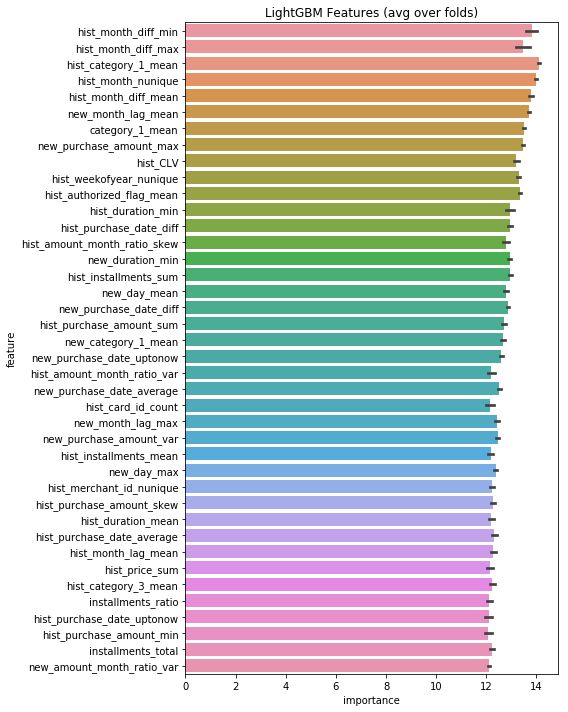

Run LightGBM with kfold - done in 391s
Full model run - done in 1315s


In [14]:
if __name__ == "__main__":
    submission_file_name = "submission.csv"
    with timer("Full model run"):
        main(debug=False)